Сгенерирую датасет, в котором есть клиенты и их информация: суммарное время проведения в неделю в спортзале (по распределению Пуассона) и информация о том, пользуется ли посетитель услугами тренера. 

In [6]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

np.random.seed(42)
num_users = 100000  
num_weeks = 12  
data = []

for week in range(1, num_weeks + 1):
    time_per_week = np.random.gamma(shape=2.0, scale=2.5, size=num_users)
    take_trainer = np.random.binomial(n=1, p=np.clip(time_per_week / time_per_week.max(), 0.05, 0.95))

    data.append(pd.DataFrame({
        "user_id": np.arange(1, num_users + 1),
        "week": week,
        "time_per_week": time_per_week,
        "take_trainer": take_trainer
    }))

df = pd.concat(data, ignore_index=True)
df.head()


,user_id,week,time_per_week,take_trainer
0,1,1,5.984198,1
1,2,1,3.736162,1
2,3,1,3.455709,0
3,4,1,3.455756,0
4,5,1,11.624286,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   user_id        1200000 non-null  int32  
 1   week           1200000 non-null  int64  
 2   time_per_week  1200000 non-null  float64
 3   take_trainer   1200000 non-null  int32  
dtypes: float64(1), int32(2), int64(1)
memory usage: 27.5 MB


Визуализируем данные

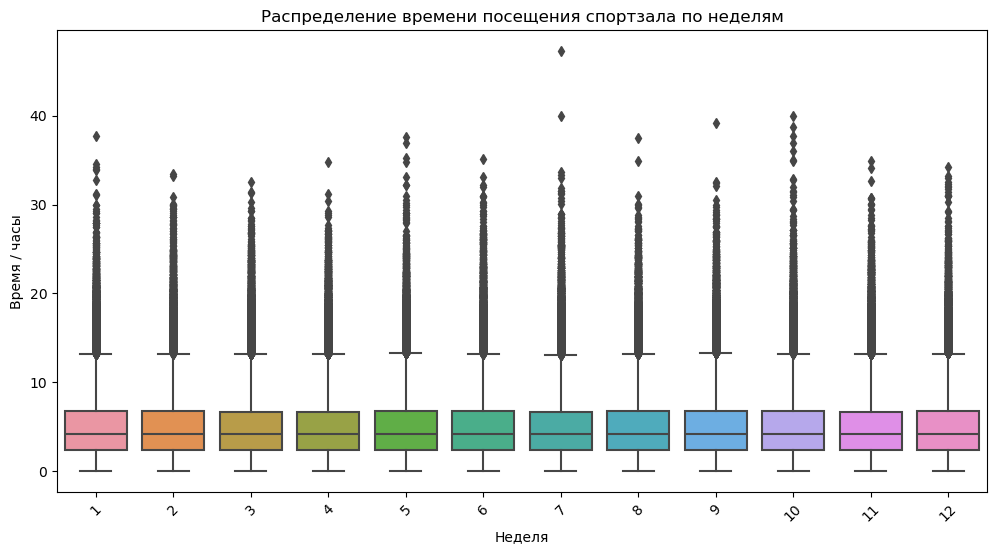

c:\Users\Katie\miniconda3\envs\mltest\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Katie\miniconda3\envs\mltest\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


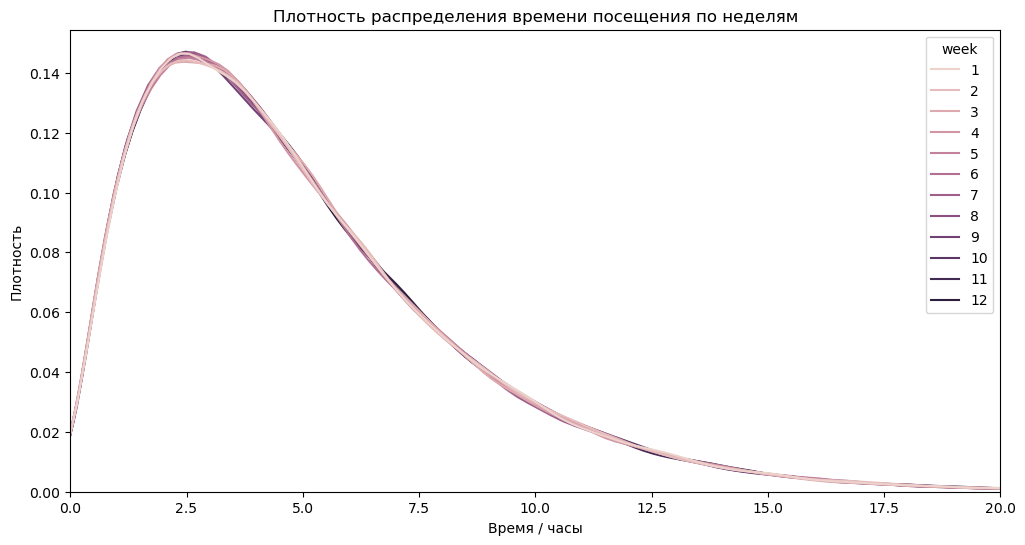

c:\Users\Katie\miniconda3\envs\mltest\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Katie\miniconda3\envs\mltest\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


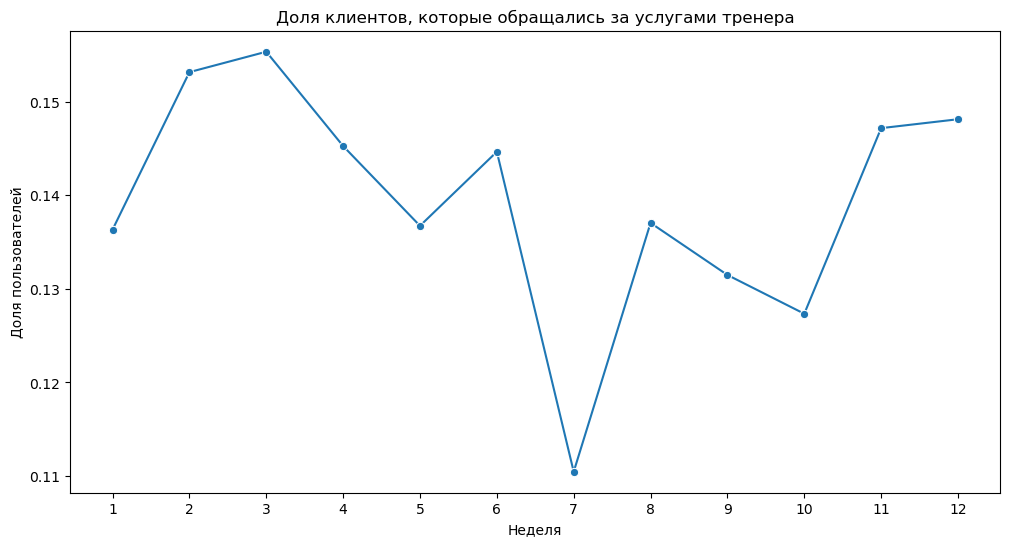

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))

sns.boxplot(x="week", y="time_per_week", data=df)
plt.title("Распределение времени посещения спортзала по неделям")
plt.xlabel("Неделя")
plt.ylabel("Время / часы")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x="time_per_week", hue="week", common_norm=False)
plt.title("Плотность распределения времени посещения по неделям")
plt.xlabel("Время / часы")
plt.ylabel("Плотность")
plt.xlim(0, 20)  
plt.show()


weekly_ratio = df.groupby("week")["take_trainer"].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=weekly_ratio.index, y=weekly_ratio.values, marker="o")
plt.title("Доля клиентов, которые обращались за услугами тренера")
plt.xlabel("Неделя")
plt.ylabel("Доля пользователей")
plt.xticks(weekly_ratio.index)
plt.show()


По графику 'Распределения времени посещения спортзала по неделям' можно заметить, что данные имеют асимметричное распределение с длинными хвостами, межквартильный размах относительно стабильный. По графику плотности распределения можно заметить, что отличий практически нет (но проверим еще с помощью мат тестов).
По последнему графику 'Доля клиентов, которые обращались за услугами тренера' можно отметить, что доля клиентов слегка колеблется. Проверим все с помощью стат тестов.

Для непрерывной метрики (кол-во часов в неделю, которые люди посещали спортзал) будем использовать критерий Колмогорова-Смирнова, а для дискретной метрики (пользовался ли клиент услугами тренера) - хи-квадрат. Сравнение будем делать для i и i+1 недели

In [23]:
from scipy.stats import ks_2samp, chi2_contingency

ks_results = []
chi2_results = []

for week in range(1, num_weeks):
    week_current = df[df["week"] == week]["time_per_week"]
    week_next = df[df["week"] == week + 1]["time_per_week"]

    ks_stat, ks_p_value = ks_2samp(week_current, week_next)
    ks_results.append([week, week + 1, ks_stat, ks_p_value])


    contingency_table = pd.crosstab(df[df["week"].isin([week, week + 1])]["week"],
                                    df[df["week"].isin([week, week + 1])]["take_trainer"])
    chi2_stat, chi2_p_value, _, _ = chi2_contingency(contingency_table)
    chi2_results.append([week, week + 1, chi2_stat, round(chi2_p_value,3)])


ks_df = pd.DataFrame(ks_results, columns=["Week 1", "Week 2", "KS Stat", "p-value (KS)"])
chi2_df = pd.DataFrame(chi2_results, columns=["Week 1", "Week 2", "Chi2 Stat", "p-value (Chi2)"])



In [21]:
ks_df

,Week 1,Week 2,KS Stat,p-value (KS)
0,1,2,0.00260,0.887034
1,2,3,0.00412,0.363074
2,3,4,0.00529,0.121357
3,4,5,0.00520,0.133371
4,5,6,0.00288,0.800125
5,6,7,0.00532,0.117555
6,7,8,0.00602,0.053134
7,8,9,0.00371,0.495681
8,9,10,0.00265,0.873026
9,10,11,0.00330,0.646303


Из таблицы можно заметить, что каждые пары имеют p-value больше 0.05, что в свою очередь свидетельствует о отсуствии статистической значимого изменения в распределении времени, которые клиенты тратили на посещение спортзала. 

In [24]:
chi2_df

,Week 1,Week 2,Chi2 Stat,p-value (Chi2)
0,1,2,114.141514,0.000
1,2,3,1.804963,0.179
2,3,4,39.625709,0.000
3,4,5,29.898031,0.000
4,5,6,25.812139,0.000
5,6,7,524.288321,0.000
6,7,8,325.265378,0.000
7,8,9,13.250182,0.000
8,9,10,7.569873,0.006
9,10,11,165.707297,0.000


Из данной таблицы можно заметить, что p-value в сравнении 2 и 3 недели, а также 11 и 12 выше значения 0.05, что говорит о том, что мы принимаем H0 гипотезу о тои, что доля клиентов, которые пользовались улсугами тренера не изменилась. Однако, для остальных пар p-value меньше 0.05 и это значит, что есть значимое изменение в доле пользователей между неделями. 

Можно сделать вывод, что некоторые недели в сравненни показали очень низкие значения p-value, которое говорит о том, что есть изменения в распределении, но также есть и недели, когда таких изменений не наблюдается. 